In [1]:
# !pip install numpy pandas matplotlib seaborn scipy statsmodels ipyleaflet

In [46]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from ipyleaflet import Map, Marker, MarkerCluster, AwesomeIcon

In [134]:
df = pd.read_csv('datasets/mta_1708.csv', error_bad_lines=False, low_memory=False, warn_bad_lines=False)

In [135]:
df.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
0,2017-08-01 00:01:03,0,Q32,W 32 ST/7 AV,40.749405,-73.991020,JACKSON HTS NORTHERN - 81 via ROOSVLT,40.755322,-73.886139,NYCT_7424,40.749403,-73.990841,W 32 ST/AV OF THE AMERICAS,< 1 stop away,220.0,2017-08-01 00:01:37,24:01:11
1,2017-08-01 00:00:52,0,B35,39 ST/1 AV,40.656456,-74.012245,BROWNSVILLE M GASTON BL via CHURCH,40.656345,-73.907188,NYCT_406,40.651330,-73.938960,CHURCH AV/E 42 ST,approaching,107.0,2017-08-01 00:02:00,23:56:12
2,2017-08-01 00:01:18,1,Q83,227 ST/113 DR,40.702263,-73.730339,JAMAICA HILLSIDE - 153 via LIBERTY,40.706795,-73.804100,NYCT_6449,40.706532,-73.804177,153 ST/HILLSIDE AV,at stop,25.0,2017-08-01 00:01:27,24:00:00
3,2017-08-01 00:01:05,0,M60-SBS,BROADWAY/W 106 ST,40.801819,-73.967644,SELECT BUS SERVICE LA GUARDIA AIRPORT,40.768074,-73.862091,NYCT_5846,40.770403,-73.917687,HOYT AV/31 ST,4.1 miles away,6519.0,2017-08-01 00:06:47,23:39:14
4,2017-08-01 00:01:05,0,M60-SBS,BROADWAY/W 106 ST,40.801819,-73.967644,SELECT BUS SERVICE LA GUARDIA AIRPORT,40.768074,-73.862091,NYCT_5846,40.770403,-73.917687,HOYT AV/31 ST,4.1 miles away,6519.0,2017-08-01 00:06:47,23:44:32


In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6463520 entries, 0 to 6463519
Data columns (total 17 columns):
RecordedAtTime               object
DirectionRef                 int64
PublishedLineName            object
OriginName                   object
OriginLat                    float64
OriginLong                   float64
DestinationName              object
DestinationLat               float64
DestinationLong              float64
VehicleRef                   object
VehicleLocation.Latitude     float64
VehicleLocation.Longitude    float64
NextStopPointName            object
ArrivalProximityText         object
DistanceFromStop             float64
ExpectedArrivalTime          object
ScheduledArrivalTime         object
dtypes: float64(7), int64(1), object(9)
memory usage: 838.3+ MB




---



**Nominal or Categorical Datatype Example**

In [137]:
df.DirectionRef.unique()

array([0, 1], dtype=int64)

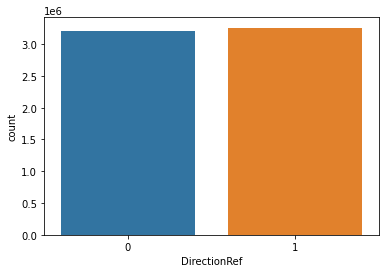

In [138]:
sns.countplot(x='DirectionRef', data=df)
plt.show()



---



**Measures of Central Tendency**

**Mean** of every numeric column(interval and ratio type data) present in the dataset

In [139]:
colMeans = df.drop('DirectionRef', axis=1).mean(axis=0, numeric_only=True)
print(colMeans)

OriginLat                     40.731087
OriginLong                   -73.931641
DestinationLat                40.729934
DestinationLong              -73.932287
VehicleLocation.Latitude      40.729874
VehicleLocation.Longitude    -73.931450
DistanceFromStop             225.168109
dtype: float64




---



**Median** of every numeric column(interval and ratio type data) present in the dataset

In [140]:
colMedians = df.drop('DirectionRef', axis=1).median(axis=0, numeric_only=True)
print(colMedians)

OriginLat                    40.715233
OriginLong                  -73.932449
DestinationLat               40.713356
DestinationLong             -73.933876
VehicleLocation.Latitude     40.723570
VehicleLocation.Longitude   -73.935840
DistanceFromStop             89.000000
dtype: float64




---



**Using Mean and Median**

To find the location which is equidistant from all the bus stops

In [141]:
from math import cos, sin, radians, atan2, sqrt, degrees, pi

pos = pd.DataFrame()

pos["Lat"] = np.hstack((df.OriginLat.dropna(), df.DestinationLat.dropna()))
pos["Lat"] = pos.Lat.apply(radians)

pos["Lon"] = np.hstack((df.OriginLong.dropna(), df.DestinationLong.dropna()))
pos["Lon"] = pos.Lon.apply(radians)

pos = pos.drop_duplicates()

pos["X"] = np.vectorize(lambda lat, lon: cos(lat)*cos(lon))(pos["Lat"], pos["Lon"])
pos["Y"] = np.vectorize(lambda lat, lon: cos(lat)*sin(lon))(pos["Lat"], pos["Lon"])
pos["Z"] = np.vectorize(sin)(pos["Lat"])

x = pos.X.mean() # pos.X.median()
y = pos.Y.mean() # pos.Y.median()
z = pos.Z.mean() # pos.Z.median()

Center_Lon = atan2(y, x)
Hyp = sqrt(x*x + y*y)
Center_Lat = atan2(z, Hyp)

print(f"Location Equidistant from all bus stops: {degrees(Center_Lat)} N, {-1*degrees(Center_Lon)} W")

Location Equidistant from all bus stops: 40.725762500951056 N, 73.93637930276239 W


The above location remains the same for both **mean** and **median** values



---



To locate the above found location on the map

In [169]:
center = (degrees(Center_Lat),degrees(Center_Lon))

m = Map(center=center, zoom=10)

icon1 = AwesomeIcon(
    name='bus',
    marker_color='red',
    icon_color='white',
    spin=False
)
marker = Marker(location=center, draggable=False, icon=icon1)

icon2 = AwesomeIcon(
    name='bus',
    marker_color='green',
    icon_color='white',
    spin=False
)

markers=list()
markers = ( Marker(location=(degrees(i[0]), degrees(i[1])), draggable=False, icon=icon2) for i in np.array(pos) )

marker_cluster = MarkerCluster( markers=tuple(markers) )

m.add_layer(marker)
m.add_layer(marker_cluster)

display(m)

Map(center=[40.725762500951056, -73.93637930276239], controls=(ZoomControl(options=['position', 'zoom_in_text'…



---



**Mode** of every column present in the dataset(Nominal, interval and ratio type data)

In [143]:
colModes = df.mode(axis=0)
colModes.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
0,2017-08-04 08:37:37,1,B6,E 126 ST/2 AV,40.80323,-73.932449,WASHINGTON HTS GW BRIDGE,40.704933,-73.79332,NYCT_5852,40.696949,-73.990592,MYRTLE AV/CEDAR ST,approaching,0.0,2017-08-15 08:17:21,18:00:00




---



**Using Mode**

To find Common Initial(origin) and Final(destination) Stops with respect to directionRef(0 or 1).

In [144]:
origins = [
    df[df.DirectionRef==i]['OriginName'].value_counts().idxmax() 
    for i in df.DirectionRef.unique()
]
print(f"Common Origins:\n\tDir-0: {origins[0]}\n\tDir-1: {origins[1]}\n")

destinations = [
    df[df.DirectionRef==i]['DestinationName'].value_counts().idxmax() 
    for i in df.DirectionRef.unique()
]
print(f"Common Destinations:\n\tDir-0: {destinations[0]}\n\tDir-1: {destinations[1]}\n")

Common Origins:
	Dir-0: MERRICK BL/ARCHER AV
	Dir-1: E 126 ST/2 AV

Common Destinations:
	Dir-0: ST GEORGE FERRY
	Dir-1: WASHINGTON HTS GW BRIDGE





---



To find the most frequent paths from those Initial Stops(origins)

In [145]:
paths_from_origins = list( map( lambda x : 
                               [ 
                                   x,
                                   df[ df.OriginName == x ][ "DestinationName" ].value_counts().idxmax(),
                                   df[ df.OriginName == x ][ "DestinationName" ].value_counts()[0]
                               ],
                               origins
                              )
                         )
print("Most Common Paths from Common Origins:\n")
k=0
for i in paths_from_origins:
    print("\tDirection Reference:", k)
    k+=1
    print("\tFrom:", i[0])
    print("\tTo:", i[1])
    print("\tNo of Trips:", i[2],"\n")

Most Common Paths from Common Origins:

	Direction Reference: 0
	From: MERRICK BL/ARCHER AV
	To: SELECT BUS BRONX ZOO via MAIN ST
	No of Trips: 37542 

	Direction Reference: 1
	From: E 126 ST/2 AV
	To: SELECT BUS SERVICE SOUTH FERRY via 2 AV
	No of Trips: 52441 





---



To find the most frequent paths to those Final Stops(destinations)

In [146]:
paths_to_destinations = list( map( lambda x : 
                               [ 
                                   x,
                                   df[ df.DestinationName == x ][ "OriginName" ].value_counts().idxmax(),
                                   df[ df.DestinationName == x ][ "OriginName" ].value_counts()[0]
                               ],
                               destinations
                              )
                         )

print("\nMost Common Paths to Common Destination:\n")
k=0
for i in paths_to_destinations:
    print("\tDirection Reference:", k)
    k+=1
    print("\tFrom:", i[0])
    print("\tTo:", i[1])
    print("\tNo of Trips:", i[2],"\n")


Most Common Paths to Common Destination:

	Direction Reference: 0
	From: ST GEORGE FERRY
	To: YUKON AV/KMART DWY
	No of Trips: 21668 

	Direction Reference: 1
	From: WASHINGTON HTS GW BRIDGE
	To: RANDALL AV/OLMSTEAD AV
	No of Trips: 30929 





---



To find the number of buses from the above initial stops to the final stops

In [148]:
ini_stop_0 = df[df["DirectionRef"]==0]['OriginName'].mode().get(0)
ini_stop_1 = df[df["DirectionRef"]==1]['OriginName'].mode().get(0)
fin_stop_1 = df[df["DirectionRef"]==1]['DestinationName'].mode().get(0)
fin_stop_0 = df[df["DirectionRef"]==0]['DestinationName'].mode().get(0)

The most frequent path with DirectionRef = 0

In [168]:
(df[df["DirectionRef"]==0][df['OriginName']==ini_stop_0].mode())[["OriginName", "DestinationName"]].head(1)

C:\Users\Anurag\AppData\Local\conda\conda\envs\apidb\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,OriginName,DestinationName
0,MERRICK BL/ARCHER AV,SELECT BUS BRONX ZOO via MAIN ST


The most frequent path with DirectionRef = 1

In [156]:
(df[df["DirectionRef"]==1][df['OriginName']==ini_stop_1].mode())[["OriginName", "DestinationName"]].head(1)

C:\Users\Anurag\AppData\Local\conda\conda\envs\apidb\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,OriginName,DestinationName
0,E 126 ST/2 AV,SELECT BUS SERVICE SOUTH FERRY via 2 AV


To find the number of buses for the above paths

In [157]:
print(df[df["DirectionRef"]==0][df['OriginName']==ini_stop_0][["OriginName", "DestinationName"]][df.DestinationName==fin_stop_0].count(),"\n")
print(df[df["DirectionRef"]==0][df['OriginName']==ini_stop_0][["OriginName", "DestinationName"]][df.DestinationName==fin_stop_1].count())

C:\Users\Anurag\AppData\Local\conda\conda\envs\apidb\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


OriginName         0
DestinationName    0
dtype: int64 



C:\Users\Anurag\AppData\Local\conda\conda\envs\apidb\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


OriginName         0
DestinationName    0
dtype: int64


We find that there are no buses directly from those most frequent initial to final stops



---



From the above results, we also find that the central tendency measures(mean, median and mode) are the same for all the numeric columns(interval type data) except for the DistanceFromStop column(ratio type data)



---



**Distribution Type**

To identify the distribution type of data using visualizations like histograms, box-plot, kernel density estimation(kdeplot) and Quantile-Quantile(qqplot).



*   Origin Latitude column


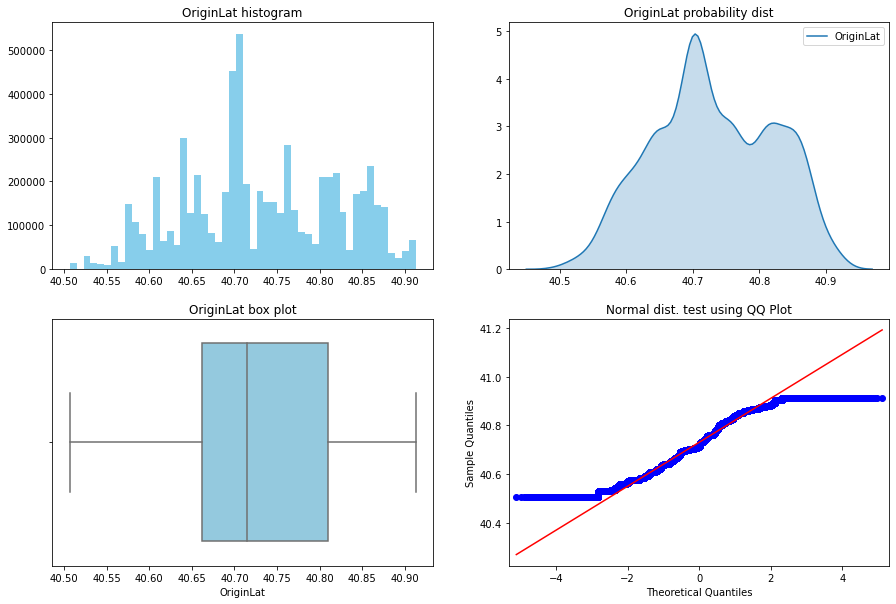

In [158]:
fig, a = plt.subplots(2, 2, figsize = (15, 10))

a[0][0].hist(df['OriginLat'].dropna(), bins=50, color="skyblue")
a[0][0].set_title('OriginLat histogram')

sns.kdeplot(df['OriginLat'].dropna(), bw=0.019, shade='blue', ax=a[0][1])
a[0][1].set_title('OriginLat probability dist')

sns.boxplot(x=df['OriginLat'].dropna(), ax=a[1][0], color="skyblue")
a[1][0].set_title('OriginLat box plot')

qqplot(df['OriginLat'].dropna(), line='s', ax=a[1][1])
a[1][1].set_title('Normal dist. test using QQ Plot')

plt.show()



*   Origin Longitude column



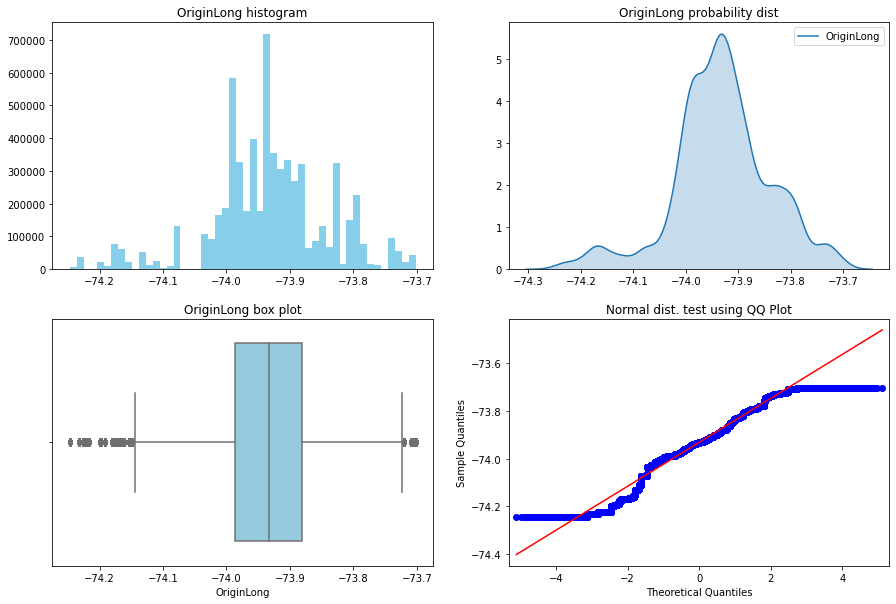

In [159]:
fig, a = plt.subplots(2, 2, figsize = (15, 10))

a[0][0].hist(df['OriginLong'].dropna(), bins=50, color='skyblue')
a[0][0].set_title('OriginLong histogram')

sns.kdeplot(df['OriginLong'].dropna(), bw=0.019, shade='blue', ax=a[0][1])
a[0][1].set_title('OriginLong probability dist')

sns.boxplot(x=df['OriginLong'].dropna(), color='skyblue', ax=a[1][0])
a[1][0].set_title('OriginLong box plot')

qqplot(df['OriginLong'].dropna(), line='s', ax=a[1][1])
a[1][1].set_title('Normal dist. test using QQ Plot')

plt.show()



*   Destination Latitude column



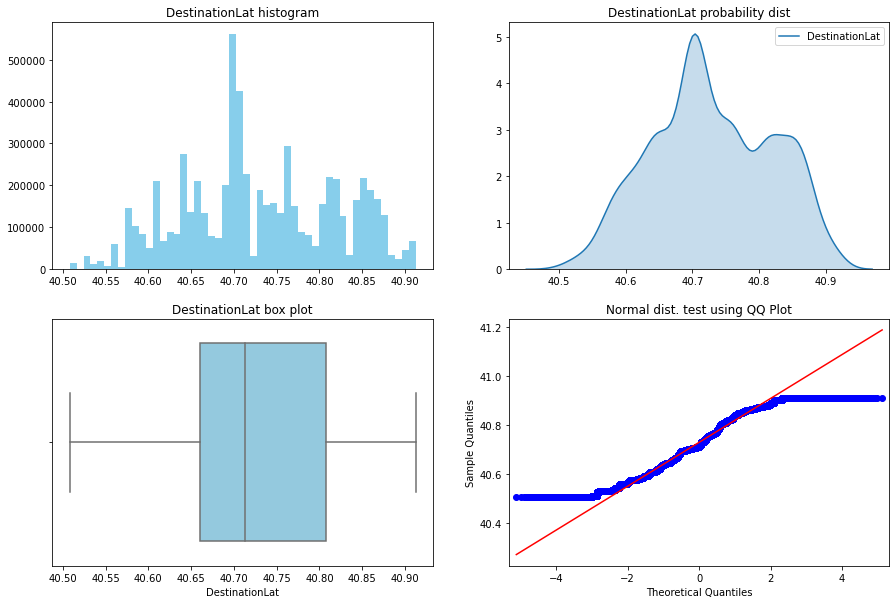

In [160]:
fig, a = plt.subplots(2, 2, figsize = (15, 10))

a[0][0].hist(df['DestinationLat'].dropna(), bins=50, color='skyblue')
a[0][0].set_title('DestinationLat histogram')

sns.kdeplot(df['DestinationLat'].dropna(), bw=0.019, shade='blue', ax=a[0][1])
a[0][1].set_title('DestinationLat probability dist')

sns.boxplot(x=df['DestinationLat'].dropna(), color='skyblue', ax=a[1][0])
a[1][0].set_title('DestinationLat box plot')

qqplot(df['DestinationLat'].dropna(), line='s', ax=a[1][1])
a[1][1].set_title('Normal dist. test using QQ Plot')

plt.show()

*   Destination Longitude column data



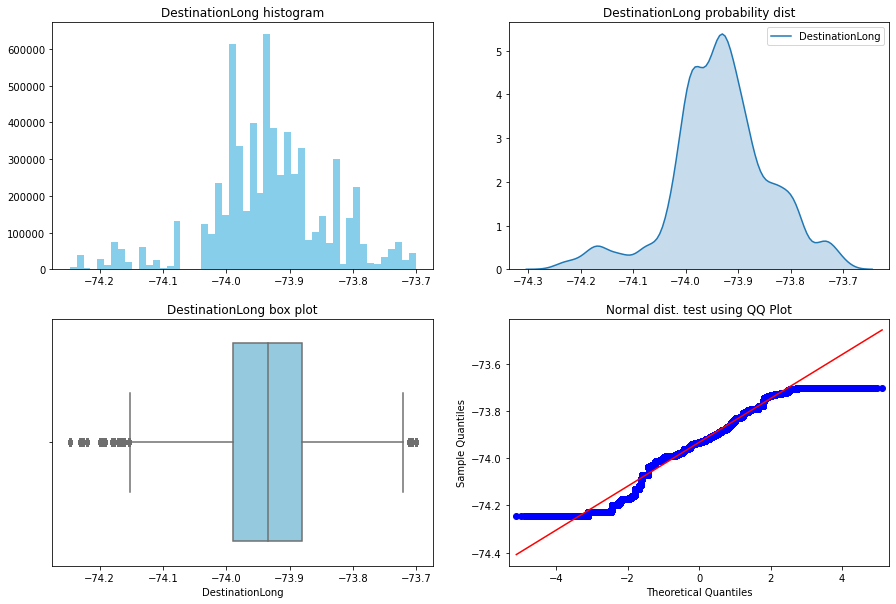

In [161]:
fig, a = plt.subplots(2, 2, figsize = (15, 10))

a[0][0].hist(df['DestinationLong'].dropna(), bins=50, color='skyblue')
a[0][0].set_title('DestinationLong histogram')

sns.kdeplot(df['DestinationLong'].dropna(), bw=0.019, shade='blue', ax=a[0][1])
a[0][1].set_title('DestinationLong probability dist')

sns.boxplot(x=df['DestinationLong'].dropna(), color='skyblue', ax=a[1][0])
a[1][0].set_title('DestinationLong box plot')

qqplot(df['DestinationLong'].dropna(), line='s', ax=a[1][1])
a[1][1].set_title('Normal dist. test using QQ Plot')

plt.show()



*   Vehicle Location Latitude column





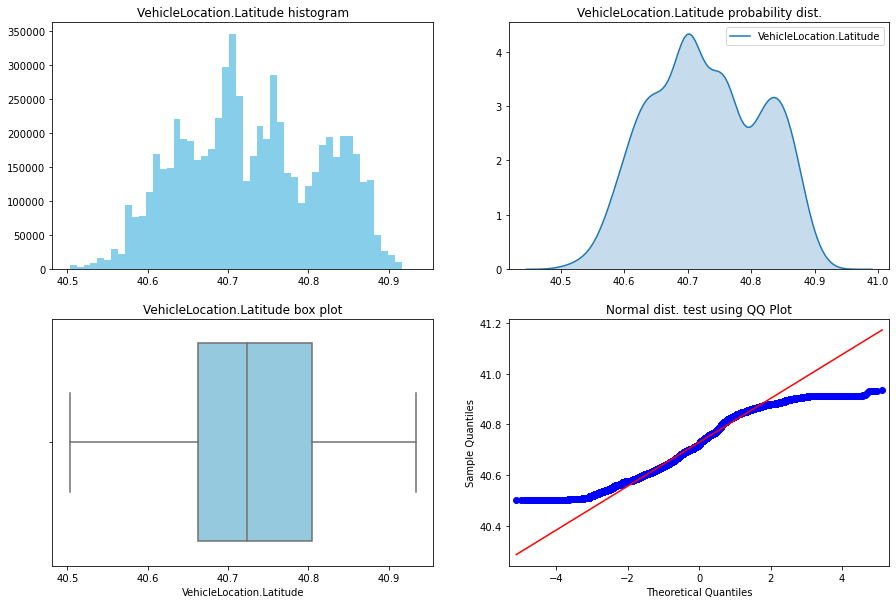

In [162]:
fig, a = plt.subplots(2, 2, figsize = (15, 10))

a[0][0].hist(df['VehicleLocation.Latitude'].dropna(), bins=50, color='skyblue')
a[0][0].set_title('VehicleLocation.Latitude histogram')

sns.kdeplot(df['VehicleLocation.Latitude'].dropna(), bw=0.019, shade='blue', ax=a[0][1])
a[0][1].set_title('VehicleLocation.Latitude probability dist.')

sns.boxplot(x=df['VehicleLocation.Latitude'].dropna(), color='skyblue', ax=a[1][0])
a[1][0].set_title('VehicleLocation.Latitude box plot')

qqplot(df['VehicleLocation.Latitude'].dropna(), line='s', ax=a[1][1])
a[1][1].set_title('Normal dist. test using QQ Plot')

plt.show()



*   Vehicle Location Longitude column



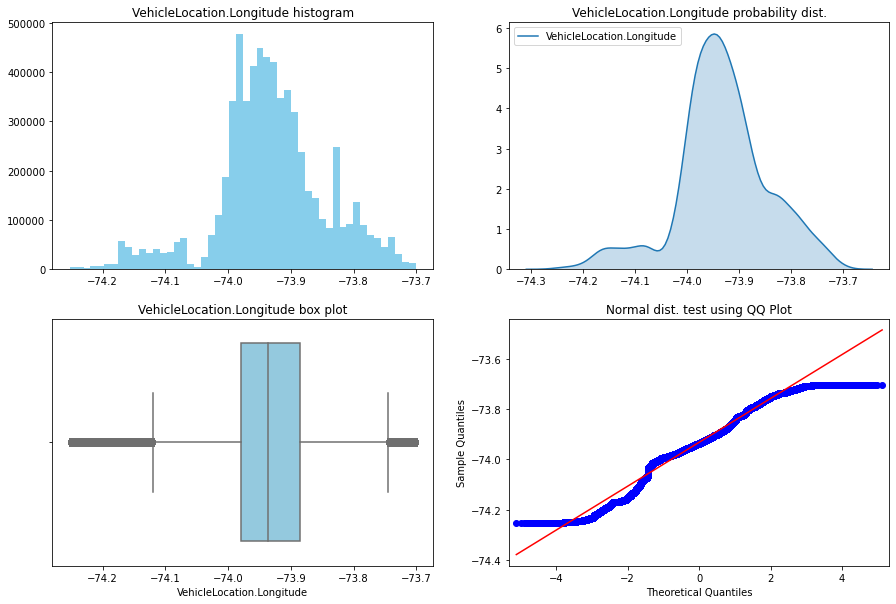

In [163]:
fig, a = plt.subplots(2, 2, figsize = (15, 10))

a[0][0].hist(df['VehicleLocation.Longitude'].dropna(), bins=50, color='skyblue')
a[0][0].set_title('VehicleLocation.Longitude histogram')

sns.kdeplot(df['VehicleLocation.Longitude'].dropna(), bw=0.019, shade='blue', ax=a[0][1])
a[0][1].set_title('VehicleLocation.Longitude probability dist.')

sns.boxplot(x=df['VehicleLocation.Longitude'].dropna(), color='skyblue', ax=a[1][0])
a[1][0].set_title('VehicleLocation.Longitude box plot')

qqplot(df['VehicleLocation.Longitude'].dropna(), line='s', ax=a[1][1])
a[1][1].set_title('Normal dist. test using QQ Plot')

plt.show()

The above plots show that, the data follows normal distribution although there is a slight deviation from the actual distribution owing to the presence of certain outliers and the fact that no real time data can be perfect. Adding to the above observations we've also pointed that the central tendency measures are all equal which is usually the case when the data follows a normal distribution.



---





*   Distance From Stop column



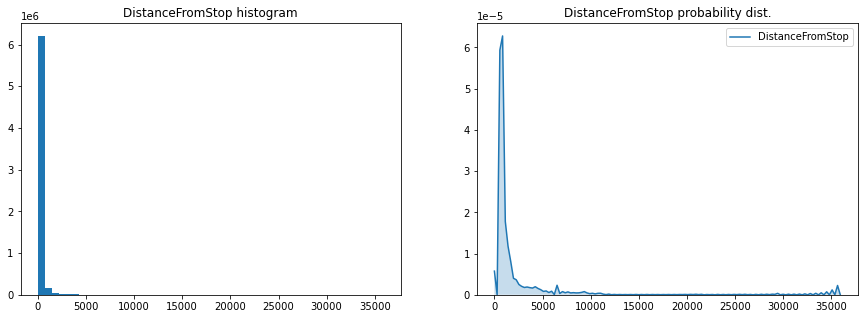

In [166]:
fig, a = plt.subplots(1, 2, figsize = (15, 5))
a[0].hist(df['DistanceFromStop'].dropna(), bins=50)
a[0].set_title('DistanceFromStop histogram')

sns.kdeplot(df['DistanceFromStop'].dropna(), bw=0.019, shade='blue', ax=a[1])
a[1].set_title('DistanceFromStop probability dist.')

plt.show()

The above plots show that DistanceFromStop follows an exponential distribution because the number of buses reaching the intended stop grows exponentially.



---

